# Import library

In [80]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

# Store dataset

In [81]:
data_raw = pd.read_csv('loan_data_2007_2014.csv', index_col=0)

C:\Users\Imam Agus Faizal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Dataset exploration

In [3]:
data_raw.shape

(466285, 74)

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [5]:
data_raw.member_id.nunique()

466285

Dapat dilihat bahwa tidak ada duplicate row pada dataset tersebut, berdasarkan kolom member_id dan id

lalu membuang kolom-kolom yang tidak dapat digunakan untuk membangun model

In [83]:
cols_to_drop = [
    # unique id
    'id'
    , 'member_id'
    
    # free text
    , 'url'
    , 'desc'
    
    # all null / constant / others
    , 'zip_code' 
    , 'annual_inc_joint'
    , 'dti_joint'
    , 'verification_status_joint'
    , 'open_acc_6m'
    , 'open_il_6m'
    , 'open_il_12m'
    , 'open_il_24m'
    , 'mths_since_rcnt_il'
    , 'total_bal_il'
    , 'il_util'
    , 'open_rv_12m'
    , 'open_rv_24m'
    , 'max_bal_bc'
    , 'all_util'
    , 'inq_fi'
    , 'total_cu_tl'
    , 'inq_last_12m'
    
    # expert judgment
    , 'sub_grade'
]

In [84]:
data = data_raw.drop(cols_to_drop, axis=1)

# Define target

Pada kasus ini, target dari prediksi adalah kolom loan status, namun pada kolom tersebut masih harus dikelompokkan menjadi 2 kategori yang lebih simple

In [8]:
data.loan_status.value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

Membagi konten kolom loan_status menjadi biner, 1 berarti bad_status(yang berisi status 'Charged Off', , 'Default' , 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)')

In [9]:
bad_status = [
    'Charged Off' 
    , 'Default' 
    , 'Does not meet the credit policy. Status:Charged Off'
    , 'Late (31-120 days)'
]

data['bad_flag'] = np.where(data['loan_status'].isin(bad_status), 1, 0)

In [11]:
data['bad_flag'].value_counts(normalize=True)

0    0.890693
1    0.109307
Name: bad_flag, dtype: float64

In [86]:
data.drop('loan_status', axis=1, inplace=True)

# Cleaning Dataset

Mengubah isi kolom-kolom yang memiliki format tanggal menjadi format angka, hal ini dilakukan karena pada saat menguji model, mesin hanya bisa membaca data dalam bentuk angka, bukan string

## emp_length

In [16]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [17]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year', '')

<ipython-input-17-a93402c6aad3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['emp_length_int'] = data['emp_length'].str.replace('\+ years', '')


In [19]:
data['emp_length_int'] = data['emp_length_int'].astype(float)

In [22]:
data.drop('emp_length', axis=1, inplace=True)

0         10.0
1          0.0
2         10.0
3         10.0
4          1.0
          ... 
466280     4.0
466281    10.0
466282     7.0
466283     3.0
466284    10.0
Name: emp_length_int, Length: 466285, dtype: float64

## term

In [23]:
data['term_int'] = data['term'].str.replace(' months', '')
data['term_int'] = data['term_int'].astype(float)

data.drop('term', axis=1, inplace=True)

## earliest_cr_line

tanggal 2017-12-01 sebagai reference date

In [24]:
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')
data['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [25]:
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
data['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [26]:
data[data['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0


Ternyata terdapat masalah, python mendefinisikan tahun 62 adalah tahun 2062, seharusnya kan tahun 1962.

bahwa nilai-nilai tersebut termasuk ke dalam data yang sudah tua (tahun 1900an), maka masih masuk akal jika mengganti nilai-nilai tersebut menjadi nilai terbesar.

In [27]:
data.loc[data['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = data['mths_since_earliest_cr_line'].max()


In [28]:
data.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

## issue_d

Sama dengan yang tadi, convert format lalu diporses dengan dikurangkan dari reference data

In [30]:
data['issue_d_date'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['issue_d_date']) / np.timedelta64(1, 'M')))

In [31]:
data.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

### last_paymnt_d

In [32]:
data['last_pymnt_d_date'] = pd.to_datetime(data['last_pymnt_d'], format='%b-%y')
data['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [33]:
data.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

### next_pymnt_d

In [34]:
data['next_pymnt_d_date'] = pd.to_datetime(data['next_pymnt_d'], format='%b-%y')
data['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

data.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1, inplace=True)

### last_credit_pull_d

In [35]:
data['last_credit_pull_d_date'] = pd.to_datetime(data['last_credit_pull_d'], format='%b-%y')
data['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

data.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

# EDA

## Correlation Check

<AxesSubplot:>

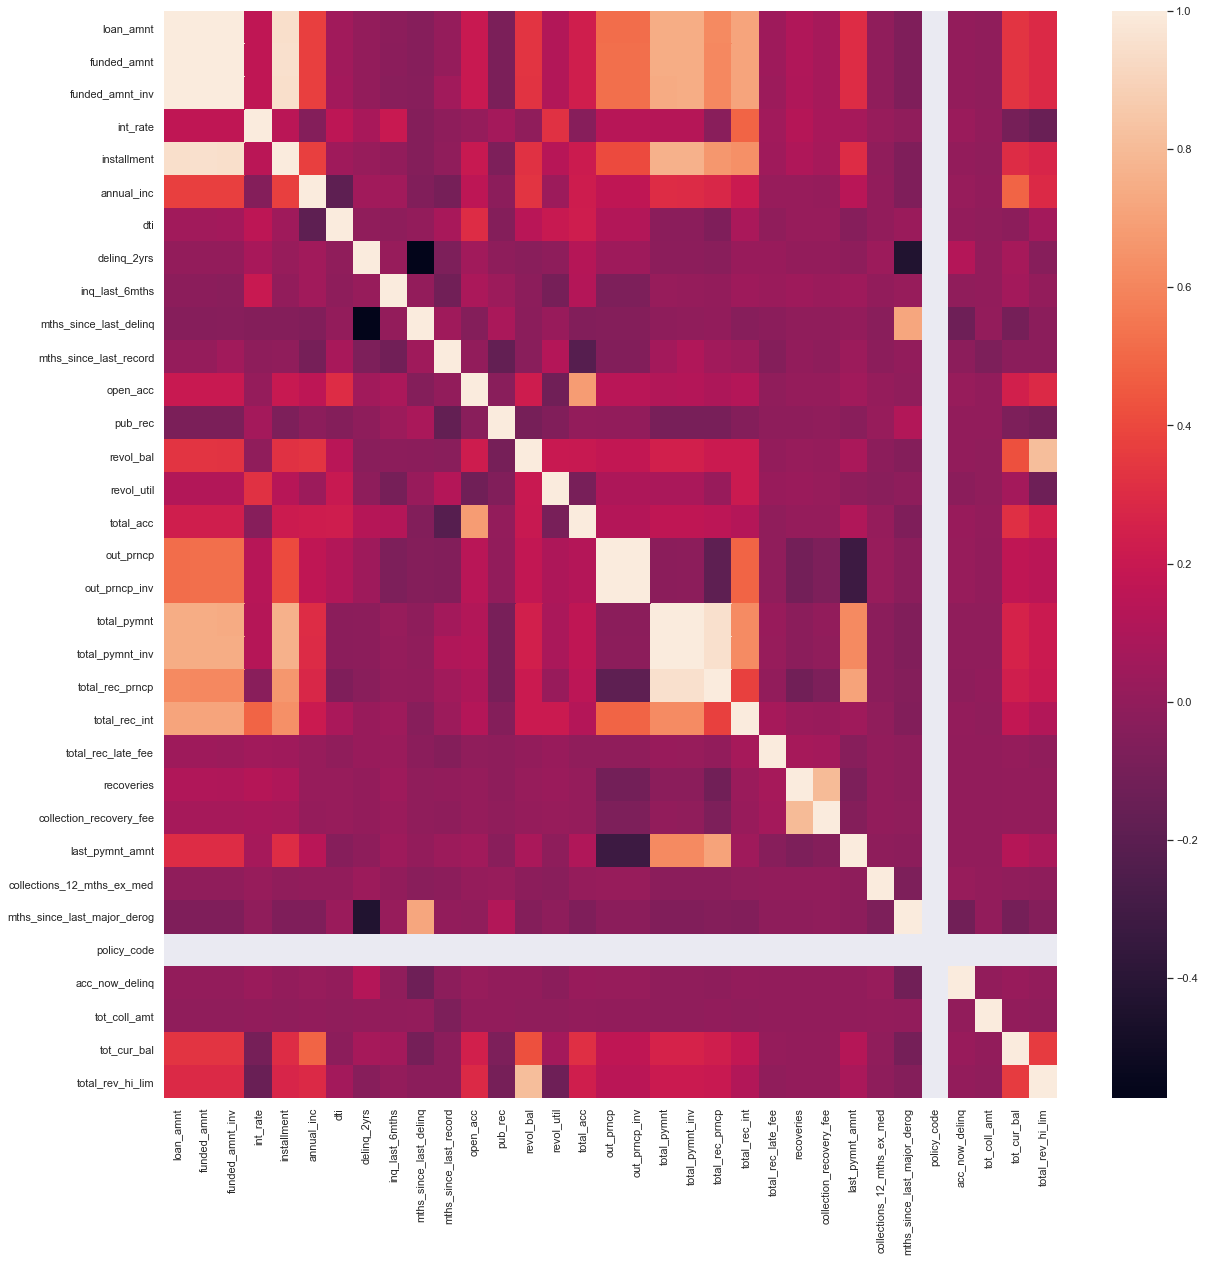

In [93]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr())

Mengambil salah satu kolom jika memiliki nilai korelasi yang tinggi, nilai korelasi yang tinffi adalah 0.7

In [94]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

<ipython-input-94-b958f315e56a>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [92]:
to_drop_hicorr

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'mths_since_last_major_derog',
 'total_rev_hi_lim']

In [95]:
data.drop(to_drop_hicorr, axis=1, inplace=True)
data

,loan_amnt,term,int_rate,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_rec_late_fee,recoveries,last_pymnt_d,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal
0,5000,36 months,10.65,B,NaN,10+ years,RENT,24000.0,Verified,Dec-11,n,credit_card,Computer,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,0.00,Jan-15,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN
1,2500,60 months,15.27,C,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,n,car,bike,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.00,0.00,117.08,Apr-13,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN
2,2400,36 months,15.96,C,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,n,small_business,real estate business,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.00,0.00,0.00,Jun-14,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN
3,10000,36 months,13.49,C,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,n,other,personel,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.00,16.97,0.00,Jan-15,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN
4,3000,60 months,12.69,B,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,n,other,Personal,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.90,0.00,0.00,Jan-16,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60 months,14.47,C,Financial Advisor,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,n,debt_consolidation,Debt consolidation,TX,19.85,0.0,Apr-03,2.0,NaN,NaN,18.0,0.0,23208,77.6,36.0,w,12574.00,0.00,0.00,Jan-16,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,294998.0
466281,22000,60 months,19.97,D,Chief of Interpretation (Park Ranger),10+ years,MORTGAGE,78000.0,Verified,Jan-14,n,debt_consolidation,Debt consolidation,TN,18.45,0.0,Jun-97,5.0,NaN,116.0,18.0,1.0,18238,46.3,30.0,f,0.00,0.00,0.00,Dec-14,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,221830.0
466282,20700,60 months,16.99,D,patrol,7 years,MORTGAGE,46000.0,Verified,Jan-14,n,debt_consolidation,Debt consolidation,OH,25.65,0.0,Dec-01,2.0,65.0,NaN,18.0,0.0,6688,51.1,43.0,f,14428.31,0.00,0.00,Jan-16,Feb-16,Dec-15,0.0,1,INDIVIDUAL,0.0,0.0,73598.0
466283,2000,36 months,7.90,A,Server Engineer Lead,3 years,OWN,83000.0,Verified,Jan-14,n,credit_card,Credit card refinancing,CA,5.39,3.0,Feb-03,1.0,13.0,NaN,21.0,0.0,11404,21.5,27.0,w,0.00,0.00,0.00,Dec-14,NaN,Apr-15,0.0,1,INDIVIDUAL,0.0,0.0,591610.0


Memeriksa feature kategorikal

In [43]:
data.select_dtypes(include='object').nunique()

grade                       7
emp_title              205475
home_ownership              6
verification_status         3
pymnt_plan                  2
purpose                    14
title                   63099
addr_state                 50
initial_list_status         2
application_type            1
dtype: int64

kolom 'emp_title', 'title' memiliki nilai unik yang amat banyak(high cardinality) dan kolom  'application_type' hanya memiliki satu nilai unik. Maka kolom-kolom tersebut tidak bisa digunakan

In [97]:
data.drop(['emp_title', 'title', 'application_type'], axis=1, inplace=True)

Memeriksa feature numerical

In [45]:
data.select_dtypes(exclude='object').nunique()

loan_amnt                        1352
int_rate                          506
annual_inc                      31901
dti                              3997
delinq_2yrs                        24
inq_last_6mths                     28
mths_since_last_delinq            145
mths_since_last_record            123
open_acc                           62
pub_rec                            26
revol_bal                       58142
revol_util                       1269
total_acc                         112
out_prncp                      135665
total_rec_late_fee               5808
recoveries                      22773
collections_12_mths_ex_med          9
policy_code                         1
acc_now_delinq                      6
tot_coll_amt                     6321
tot_cur_bal                    220690
bad_flag                            2
emp_length_int                     11
term_int                            2
mths_since_earliest_cr_line       515
mths_since_issue_d                 91
dtype: int64

In [46]:
data.drop(['policy_code'], axis=1, inplace=True)

membuat perulangan untuk memeriksa kolom-kolom kategorikal

In [47]:
for col in data.select_dtypes(include='object').columns.tolist():
    print(data[col].value_counts(normalize=True)*100)
    print('\n')

B    29.365946
C    26.870476
D    16.489486
A    16.056060
E     7.668486
F     2.837106
G     0.712440
Name: grade, dtype: float64


MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.039032
NONE         0.010723
ANY          0.000214
Name: home_ownership, dtype: float64


Verified           36.041262
Source Verified    32.167666
Not Verified       31.791072
Name: verification_status, dtype: float64


n    99.99807
y     0.00193
Name: pymnt_plan, dtype: float64


debt_consolidation    58.804165
credit_card           22.337626
home_improvement       5.691155
other                  5.080584
major_purchase         2.107724
small_business         1.504016
car                    1.157447
medical                0.986950
moving                 0.642097
vacation               0.533365
wedding                0.502482
house                  0.486612
educational            0.090503
renewable_energy       0.075276
Name: purpose, dtype: float64


CA    15.323247
NY  

kolom 'pymnt_plan' didominasi oleh salah satu nilai saja, maka harus dibuang

In [48]:
data.drop('pymnt_plan', axis=1, inplace=True)

## Memeriksa missing value

In [54]:
check_missing = data.isnull().sum() * 100 / data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)
#check_missing.sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_delinq         53.690554
tot_coll_amt                   15.071469
tot_cur_bal                    15.071469
emp_length_int                  4.505399
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
delinq_2yrs                     0.006219
inq_last_6mths                  0.006219
open_acc                        0.006219
pub_rec                         0.006219
total_acc                       0.006219
acc_now_delinq                  0.006219
mths_since_earliest_cr_line     0.006219
annual_inc                      0.000858
dtype: float64

Membuang kolom yang memiliki missing value melebihi 75%

In [55]:
data.drop('mths_since_last_record', axis=1, inplace=True)

Mengisi missing value

In [56]:
data['annual_inc'].fillna(data['annual_inc'].mean(), inplace=True)
data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
data['acc_now_delinq'].fillna(0, inplace=True)
data['total_acc'].fillna(0, inplace=True)
data['pub_rec'].fillna(0, inplace=True)
data['open_acc'].fillna(0, inplace=True)
data['inq_last_6mths'].fillna(0, inplace=True)
data['delinq_2yrs'].fillna(0, inplace=True)
data['collections_12_mths_ex_med'].fillna(0, inplace=True)
data['revol_util'].fillna(0, inplace=True)
data['emp_length_int'].fillna(0, inplace=True)
data['tot_cur_bal'].fillna(0, inplace=True)
data['tot_coll_amt'].fillna(0, inplace=True)
data['mths_since_last_delinq'].fillna(-1, inplace=True)

## Feature scaling dan encoding

In [57]:
categorical_cols = [col for col in data.select_dtypes(include='object').columns.tolist()]

onehot = pd.get_dummies(data[categorical_cols], drop_first=True)

onehot.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
numerical_cols = [col for col in data.columns.tolist() if col not in categorical_cols + ['bad_flag']]

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(data[numerical_cols]), columns=numerical_cols)

In [59]:
std.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,emp_length_int,term_int,mths_since_earliest_cr_line,mths_since_issue_d
0,-1.124392,-0.729587,-0.896551,1.328632,-0.357012,0.178920,-0.708792,-1.641166,-0.31429,-0.124888,1.159498,-1.384557,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,1.764941,1.446626
1,-1.426088,0.330634,-0.787387,-2.065791,-0.357012,3.843328,-0.708792,-1.641166,-0.31429,-0.703378,-1.965980,-1.815538,-0.693944,-0.123464,0.057470,-0.083608,-0.058307,-0.012089,-0.792648,-1.523744,1.622784,-0.212426,1.446626
2,-1.438156,0.488979,-1.110294,-1.082491,-0.357012,1.095022,-0.708792,-1.841641,-0.31429,-0.642003,1.782070,-1.298361,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,-0.570896,1.446626
3,-0.521001,-0.077850,-0.438063,0.354248,-0.357012,0.178920,0.860811,-0.237839,-0.31429,-0.514224,-1.478018,1.028934,-0.693944,3.099264,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,0.226989,1.446626
4,-1.365749,-0.261438,0.122311,0.091865,-0.357012,-0.737182,0.991612,0.764538,-0.31429,0.558748,-0.094058,1.115130,-0.573268,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,-1.257509,1.622784,0.238553,1.446626


Menggabungkan kembali kolom-kolom hasil transformasi 

In [64]:
data_model = pd.concat([onehot, std, data[['bad_flag']]], axis=1)
data_model

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,emp_length_int,term_int,mths_since_earliest_cr_line,mths_since_issue_d,bad_flag
0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.124392,-0.729587,-0.896551,1.328632,-0.357012,0.178920,-0.708792,-1.641166,-0.314290,-0.124888,1.159498,-1.384557,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,1.764941,1.446626,0
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.426088,0.330634,-0.787387,-2.065791,-0.357012,3.843328,-0.708792,-1.641166,-0.314290,-0.703378,-1.965980,-1.815538,-0.693944,-0.123464,0.057470,-0.083608,-0.058307,-0.012089,-0.792648,-1.523744,1.622784,-0.212426,1.446626,1
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.438156,0.488979,-1.110294,-1.082491,-0.357012,1.095022,-0.708792,-1.841641,-0.314290,-0.642003,1.782070,-1.298361,-0.693944,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,-0.570896,1.446626,0
3,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.521001,-0.077850,-0.438063,0.354248,-0.357012,0.178920,0.860811,-0.237839,-0.314290,-0.514224,-1.478018,1.028934,-0.693944,3.099264,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,0.226989,1.446626,0
4,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.365749,-0.261438,0.122311,0.091865,-0.357012,-0.737182,0.991612,0.764538,-0.314290,0.558748,-0.094058,1.115130,-0.573268,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,-1.257509,1.622784,0.238553,1.446626,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.492696,0.147046,0.668130,0.335143,-0.3

## Modelling

Train-Test Split

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X = data_model.drop('bad_flag', axis=1)
y = data_model['bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
X_train.shape, X_test.shape

((373028, 99), (93257, 99))

In [110]:
from sklearn.metrics import roc_curve, roc_auc_score

algoritma Random Forest untuk pemodelan

In [114]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [118]:
arr_feature_importances = rfc.feature_importances_
arr_feature_names = X_train.columns.values
    
df_feature_importance = pd.DataFrame(index=range(len(arr_feature_importances)), columns=['feature', 'importance'])
df_feature_importance['feature'] = arr_feature_names
df_feature_importance['importance'] = arr_feature_importances
df_all_features = df_feature_importance.sort_values(by='importance', ascending=False)
df_all_features

,feature,importance
90,recoveries,5.686628e-01
88,out_prncp,1.425707e-01
89,total_rec_late_fee,9.117926e-02
77,int_rate,7.211943e-02
3,grade_E,1.669316e-02
98,mths_since_issue_d,1.551734e-02
78,annual_inc,1.216729e-02
4,grade_F,1.198979e-02
0,grade_B,9.384115e-03
94,tot_cur_bal,9.277054e-03


metrik yang umum dipakai dalam dunia credit risk adalah AUC

In [119]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

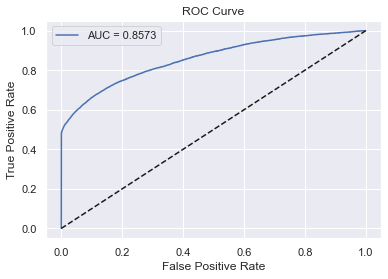

In [120]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

Fitting train model ke dalam logistic regression dan melakukan prediksi score

In [67]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

Y_pred = clf.predict(X_test)
accuracy_score(y_test, Y_pred)

C:\Users\Imam Agus Faizal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.93961847368026

Melakukan validation terhadap test dataset, menggunakan model yang train

In [69]:
test = pd.read_csv('loan_data_2007_2014.csv')

C:\Users\Imam Agus Faizal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Prediksi terhadap kolom bad_flag

In [73]:
test = data_model.drop(['bad_flag'], axis = 1)
pred = clf.predict(test)
pred

array([0, 1, 0, ..., 0, 0, 0])

Menyimpan hasil prediksi pada file predictionGacor.csv

In [74]:
predictionGacor = pd.DataFrame({
        "member_id": data_raw["member_id"],
        "bad_flag": pred
    })
predictionGacor.to_csv('predictionGacor.csv', index=False)

<AxesSubplot:xlabel='bad_flag', ylabel='count'>

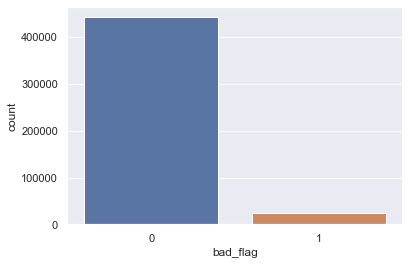

In [107]:
pred_df = pd.read_csv('predictionGacor.csv')
sns.countplot(x='bad_flag', data=predictionGacor)

<AxesSubplot:xlabel='bad_flag', ylabel='count'>

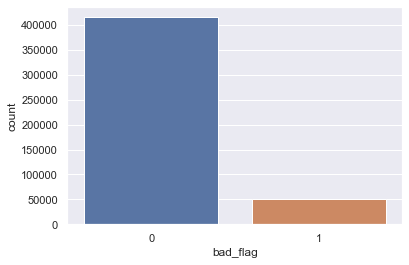

In [77]:
sns.countplot(x='bad_flag', data=data_model)

In [102]:
predictionGacor.bad_flag.value_counts(normalize=True)

0    0.949256
1    0.050744
Name: bad_flag, dtype: float64

In [103]:
data_model.bad_flag.value_counts(normalize=True)

0    0.890693
1    0.109307
Name: bad_flag, dtype: float64

In [108]:
pred_df

,member_id,bad_flag
0,1296599,0
1,1314167,1
2,1313524,0
3,1277178,0
4,1311748,0
...,...,...
466280,1440975,0
466281,11536848,0
466282,11436914,0
466283,11457002,0
